# CS4619 - Artificial Intelligence II - Continuous Assessment
This notebook contains the continuous assessment work of Jack Moloney (120492066) for CS4619's CA.

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Input
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

from tensorflow.keras.utils import image_dataset_from_directory

## Dataset Loading
Before we can perform any training or analysis we must first load the images to tensorflow Dataset objects.

In [1]:
dataset_dir = "dataset_zebra_tigers"

In [6]:
train_dir = os.path.join(dataset_dir, "train")
val_dir = os.path.join(dataset_dir, "val")
test_dir = os.path.join(dataset_dir, "test")

I have decided that I will be using ResNet as the base model to perform transfer learning from - this means that when loading the images as a dataset I will be enforcing the correct input size of (224,224).

In [7]:
train_dataset = image_dataset_from_directory(
    train_dir, label_mode="binary", image_size=(224, 224)
)
val_dataset = image_dataset_from_directory(
    val_dir, label_mode="binary", image_size=(224, 224)
)
test_dataset = image_dataset_from_directory(
    test_dir, label_mode="binary", image_size=(224, 224)
)

Found 100 files belonging to 2 classes.
Found 150 files belonging to 2 classes.
Found 150 files belonging to 2 classes.


In [15]:
class_names = train_dataset.class_names
print(f"Class names: {class_names}")

Class names: ['tiger', 'zebra']


2025-01-24 15:43:41.180545: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


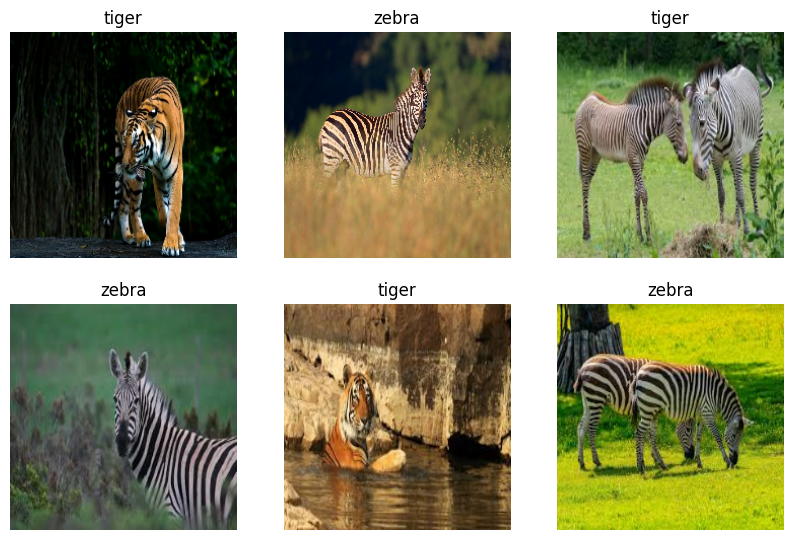

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(2):
    for i in range(6):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[i%2])
        plt.axis("off")
plt.show()

as shown above, the images have successfully been loaded to the dataset as 224 * 224 square images and are ready for resnet.

## Base Model
We will now create a simple base model from which we can build other (transfer learning) models.

In [23]:
resnet50_base = ResNet50(
    weights="imagenet", include_top=False, input_shape=(224, 224, 3)
)
resnet50_base.trainable = False
resnet50_base.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

## First Model

Now lets train our first model using the dataset as is and evaluate the performance.

In [26]:
inputs = Input(shape=(224, 224, 3)) # The '3' represents the number of channels - BRG
x = preprocess_input(inputs) # built-in preprocessing layer to prepare images for ResNet 50
resnet_base = ResNet50(
    weights="imagenet", include_top=False, input_tensor=x, name="resnet50_base"
)
x = resnet_base.output
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
outputs = Dense(1, activation="sigmoid")(x)

# Create the final model
model = Model(inputs=inputs, outputs=outputs)

In [27]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 224, 224)  │          0 │ input_layer_3[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 224, 224)  │          0 │ input_layer_3[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 224, 224)  │          0 │ input_layer_3[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_1 (Stack)     │ (None, 224, 224,  │          0 │ get_item_3[0][0], │
│                     │ 3)                │            │ get_item_4[0][0], │
│                     │                   │            │ get_item_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 224, 224,  │          0 │ stack_1[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ add_1[0][0]       │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 49,278,337 (187.98 MB)

 Trainable params: 49,225,217 (187.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

### Train

In [28]:
model.compile(
    optimizer=RMSprop(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

When training, we will use early stopping to ensure that the model is improving; once it doesn't improve for 4 epochs it will stop.

In [29]:
model_history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)
    ],
)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 30s 5s/step - accuracy: 0.5148 - loss: 8.6574 - val_accuracy: 0.9800 - val_loss: 0.0319
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - accuracy: 1.0000 - loss: 0.0060 - val_accuracy: 0.9800 - val_loss: 0.0413
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 0.9667 - val_loss: 0.0789
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - accuracy: 0.9868 - loss: 0.0314 - val_accuracy: 0.9267 - val_loss: 0.2441
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - accuracy: 0.9960 - loss: 0.0064 - val_accuracy: 0.9800 - val_loss: 0.0313
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - accuracy: 1.0000 - loss: 2.7013e-04 - val_accuracy: 0.9867 - val_loss: 0.0309
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - accuracy: 1.0000 - loss: 3.3086e-04 - val_accuracy: 0.9867 - val_loss: 0.0252
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - accuracy: 1.0000 - loss: 3.3168e-04 - val_accuracy: 0.9667 - val_loss: 0.0